In [1]:
import os
os.chdir("../")

In [2]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from argparse import Namespace
%matplotlib inline

In [3]:
from src.datasets.vanderpol import VanderPol, plot_vanderpol

from src.gpode.model_builder import build_model, compute_loss, compute_predictions, compute_test_predictions
from src.gpode.model_builder import Trainer
from src.gpode.model_initialization import initialize_inducing, initialize_latents_with_data

from src.misc.plot_utils import plot_model_initialization, plot_longitudinal, plot_vectorfield_posterior
from src.misc.settings import settings
from src.misc.torch_utils import numpy2torch, torch2numpy

/data/work/gpode/codebase/gaussian-process-odes/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
device = settings.device

if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
# setup all the experiment parameters
args = Namespace(**{ 
    'num_features':256,  # number of RFF features for sampling from GP prior
    'num_inducing':16,   # number of inducing points for variational GP posterior
    'q_diag':False,      # diagonal posterior assumption for inducing variables
    'dimwise':True,      # keep separate kernel parameters for ODE transition
    
    'data_obs_S':25,     # observation sequence length for training data
    'data_obs_T':7,      # observation time for training data
    'data_obs_noise_var':0.01, # observation noise std dev
    
    'solver':'dopri5',   # ODE integrator
    'use_adjoint':False, # use adjoint method for gradient computation
    'ts_dense_scale':2,  # number of time steps to evaluate between every observation
    
    'num_iter':2_000,   # optimization iterations
    'lr':0.001,          # optimization learning rate
     
    'log_freq':20,       # logging frequency
})

### Generating data 

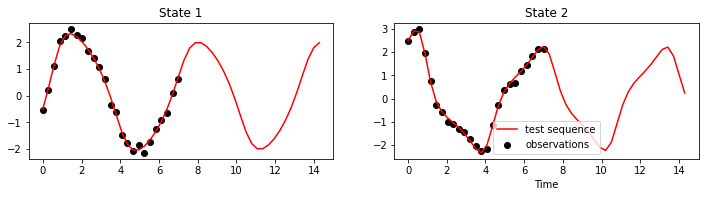

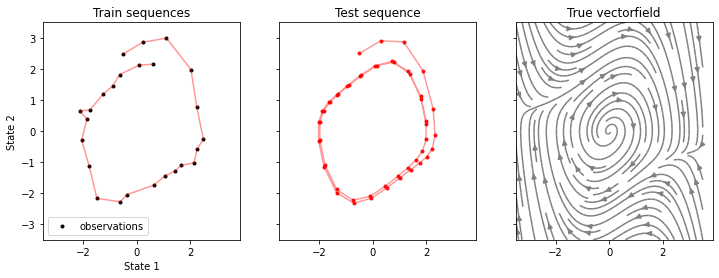

In [6]:
n_ahead = args.data_obs_S
data = VanderPol(S_train=args.data_obs_S, T_train=args.data_obs_T,
                 S_test=args.data_obs_S + n_ahead,
                 T_test=(args.data_obs_T * (args.data_obs_S + n_ahead - 1) / (args.data_obs_S - 1)),
                 noise_var=args.data_obs_noise_var,
                 x0 = np.array([[-0.5, 2.5]])
                )

plot_vanderpol(data)

In [7]:
train_ys = torch.tensor(data.trn.ys)
train_ts = torch.tensor(data.trn.ts)

test_ys = torch.tensor(data.tst.ys)
test_ts = torch.tensor(data.tst.ts)

### Model definition and initialization

We use empirical gradients to initialize the vector field close to ground truth. The following plot shows the GPODE vector field after model initialization.  

In [8]:
model = build_model(args, data.trn.ys)
model = initialize_inducing(model, data.trn.ys, data.trn.ts.max())
model = initialize_latents_with_data(model, data.trn.ys, data.trn.ts)

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.70it/s]


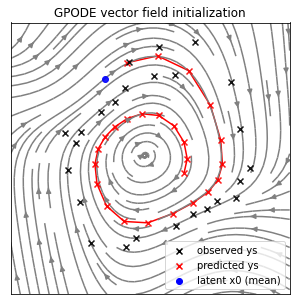

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_model_initialization(ax, data, model, train_ys, train_ts, 
                          compute_predictions, has_latents=False)
ax.set_title('GPODE vector field initialization')
plt.show()

### Optimization

In [10]:
trainer = Trainer()
model, _ = trainer.train(model = model,
                         loss_function = compute_loss,
                         ys = train_ys, ts = train_ts, 
                         num_iter = args.num_iter, 
                         lr = args.lr, 
                         log_freq = args.log_freq)

In [11]:
print("Observation noise variance:")
print(model.likelihood.variance.data)
print("kernel lengthscales:")
print(model.flow.odefunc.diffeq.kern.lengthscales.data)
print("kernel signal variance:")
print(model.flow.odefunc.diffeq.kern.variance.data)

Observation noise variance:
tensor([0.0629, 0.0737])
kernel lengthscales:
tensor([[1.6389, 1.4374],
        [1.2672, 1.6165]])
kernel signal variance:
tensor([0.5320, 0.5296])


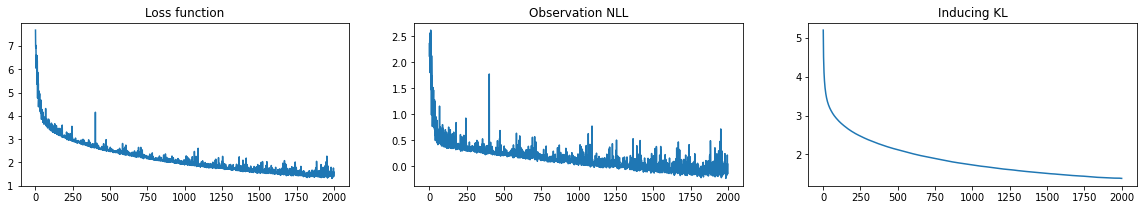

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3))

ax1.plot(trainer.loss_meter.iters, 
         trainer.loss_meter.vals)
ax1.set_title("Loss function")
ax2.plot(trainer.observ_nll_meter.iters, 
         trainer.observ_nll_meter.vals)
ax2.set_title("Observation NLL")
ax3.plot(trainer.inducing_kl_meter.iters, 
         trainer.inducing_kl_meter.vals)
ax3.set_title("Inducing KL")
plt.show()

### Visualize model predictions

In [13]:
test_pred = torch2numpy(compute_predictions(model, ts=test_ts, eval_sample_size=64))

100%|███████████████████████████████████████████| 64/64 [00:18<00:00,  3.54it/s]


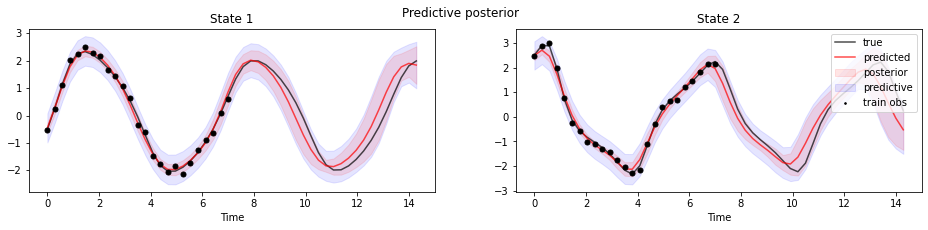

In [14]:
plot_longitudinal(data, test_pred, torch2numpy(model.likelihood.variance))

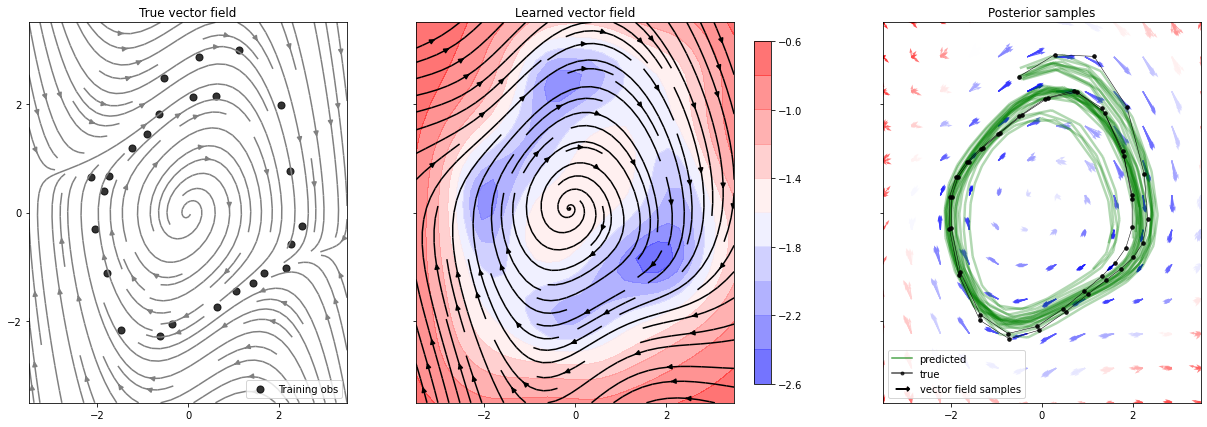

In [15]:
plot_vectorfield_posterior(model, data, test_pred)